## EDA
Notebook z eksploracją danych wytworzoną na potrzeby implementacji oraz generacji modelu RVC.  
Zawiera wszystkie potrzebne inspekcje danych oraz ręczną weryfikację funkcjonowania komponentów modelu RVC.
Na końcu zamieściliśmy również prosty poradnik do uruchamiania całego pipeline'u krok po kroku.

In [ ]:
# Importy, konfiguracja + sciezki do plikow
from pathlib import Path
from typing import List, Dict, Any, Tuple

import numpy as np
import pandas as pd
import torch
import torchaudio
from torchaudio import transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm

import faiss

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

TRAIN_AUDIO_DIR = Path("../data/my_voice/")
INFERENCE_AUDIO_PATH = Path("../data/references/california_gurls.mp3")

RMVPE_CKPT_PATH = Path("saved_models/rmvpe/rmvpe.pt")
HUBERT_CKPT_PATH = Path("saved_models/hubert/ubert.pt")
GENERATOR_CKPT_PATH = Path("saved_models/generators/generator.pt")

TARGET_SAMPLE_RATE = 16000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)
print("Train dir exists:", TRAIN_AUDIO_DIR.exists())
print("Inference audio exists:", INFERENCE_AUDIO_PATH.exists())

Device: cpu
Train dir exists: True
Inference audio exists: True


Na początku tworzymy pomocnicze funkcje do obróbki danych, ich wstępnej analizy oraz, przede wszystkim, do ich załadowania.
Poniżej: 
- list_audio_files: rekurencyjnie wyszukuje pliki audio w katalogu treningowym.
- load_audio: ładuje dźwięk, konwertuje do mono, resampluje do TARGET_SAMPLE_RATE i normalizuje amplitudę.
- audio_metadata: liczy liczbę kanałów, liczba próbek, sample rate, czas trwania.

In [ ]:
# Funkcje do ladowania, obrobki oraz uzyskiwania danych z plikow audio

def list_audio_files(root: Path, exts=(".wav", ".flac", ".mp3", ".ogg")) -> List[Path]:
    files = []
    for ext in exts:
        files.extend(root.rglob(f"*{ext}"))
    return sorted(files)


def load_audio(path: Path, target_sr: int = TARGET_SAMPLE_RATE) -> Tuple[np.ndarray, int]:
    waveform, sr = torchaudio.load(path)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != target_sr:
        resampler = T.Resample(orig_freq=sr, new_freq=target_sr)
        waveform = resampler(waveform)
        sr = target_sr
    waveform = waveform / max(waveform.abs().max(), 1e-9)
    return waveform.squeeze(0).numpy().astype(np.float32), sr


def audio_metadata(path: Path) -> Dict[str, Any]:
    try:
        waveform, sr = torchaudio.load(str(path))  # [channels, num_frames]
        num_channels, num_frames = waveform.shape
        duration = num_frames / sr if sr > 0 else 0.0
        return {
            "path": str(path),
            "sample_rate": sr,
            "num_frames": int(num_frames),
            "num_channels": int(num_channels),
            "duration_sec": float(duration),
        }
    except Exception as e:
        return {
            "path": str(path),
            "error": str(e),
        }


train_files = list_audio_files(TRAIN_AUDIO_DIR)
print(f"Found {len(train_files)} training audio files.")
if train_files:
    print("First few files:")
    for p in train_files[:5]:
        print("  -", p)


Found 5 training audio files.
First few files:
  - ..\data\my_voice\List_1.wav
  - ..\data\my_voice\List_2.wav
  - ..\data\my_voice\List_3.wav
  - ..\data\my_voice\List_4.wav
  - ..\data\my_voice\List_5.wav


Następnie tworzymy podstawowe wizualizację metadanowe dotyczące załadowanych plików:
- rozkład długości danych treningowych
- rozład częstotliwości próbkowania danych treningowych (ważne, gdyż nasza architektura RVC, głównie HuBert, przyjmują dane o częstotliwości próbkowania 16KHz)
Również prowadzimy weryfikację danych (czy pliki nie są uszkodzone, czy zostały załadowane poprawnie).

Scanning train audio: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


,path,sample_rate,num_frames,num_channels,duration_sec
0,..\data\my_voice\List_1.wav,44100,1471646,1,33.370658
1,..\data\my_voice\List_2.wav,44100,1318174,1,29.890567
2,..\data\my_voice\List_3.wav,44100,1489720,1,33.780499
3,..\data\my_voice\List_4.wav,44100,1310251,1,29.710907
4,..\data\my_voice\List_5.wav,44100,1376820,1,31.220408


Number of valid files: 5
Total duration (hours): 0.043881399596875786


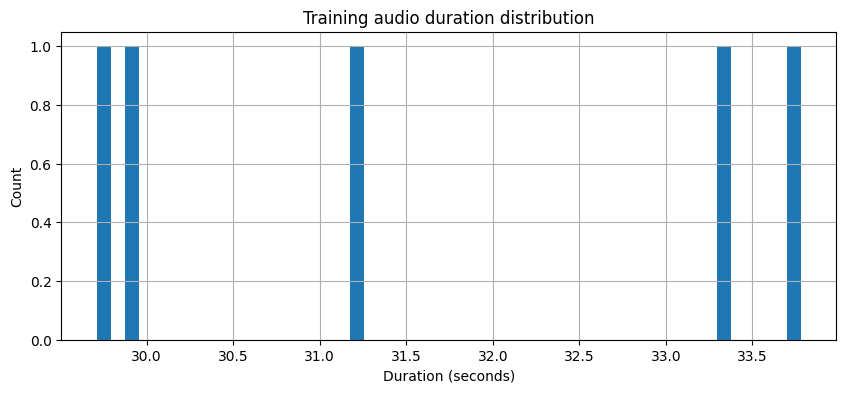

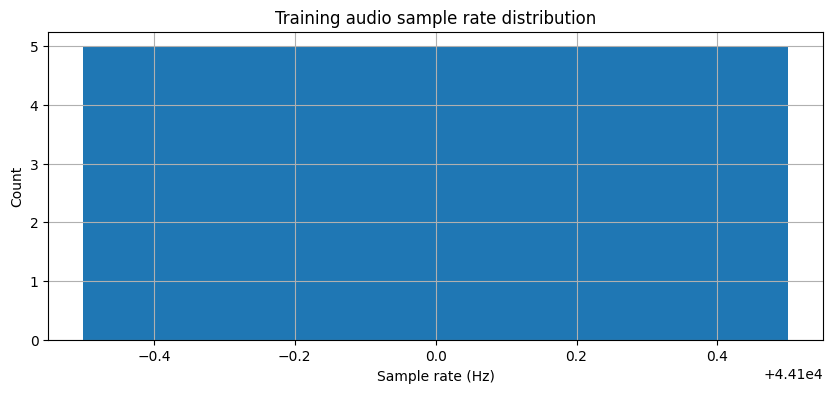

In [ ]:
# metadane dla nagran audio
# tworzymy ramke danych z podstawowymi informacjami do pozniejszej weryfikacji
meta_records = [audio_metadata(p) for p in tqdm(train_files, desc="Scanning train audio")]
meta_df = pd.DataFrame(meta_records)

display(meta_df.head())

valid_meta_df = meta_df[meta_df["duration_sec"].notna() & meta_df["sample_rate"].notna()]

print("Number of valid files:", len(valid_meta_df))
print("Total duration (hours):", valid_meta_df["duration_sec"].sum() / 3600.0)

plt.figure()
plt.hist(valid_meta_df["duration_sec"], bins=50)
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Training audio duration distribution")
plt.show()

plt.figure()
plt.hist(valid_meta_df["sample_rate"], bins=len(valid_meta_df["sample_rate"].unique()))
plt.xlabel("Sample rate (Hz)")
plt.ylabel("Count")
plt.title("Training audio sample rate distribution")
plt.show()


Szybkie wnioski z powyższej wizualizacji:
- Pliki mają podobną długość mowy co gwarantuje balans pomiędzy danymi wejściowymi
- Ta sama częstotliwość próbkowania dla każdego pliku, co jest wymagane dla dalszej ewaluacji modelu (łatwo dokonać resamplingu)
- Zbadano dość podstawowe właściwości zbadane dla danych, choć ów wstępna weryfikacja jest przydatna

W kolejnym kroku dokonujemy dalszej inspekcji danych poprzez:
- ładowanie jest pierwszego pliku z głosem treningowym oraz pliku z piosenką do inferencji (obu na docelowej częstotliwości próbkowania).
- wizualizujemy przebieg czasowy pierwszych kilkunastu sekund nagrania treningowego oraz przebieg czasowy pierwszych kilkunastu sekund piosenki.

Potwierdzamy tym "naturalność" sygnałów wejściowych, które później przechodzą przez preprocessing, HuBERT, RMVPE i generator.

Train sample: ..\data\my_voice\List_1.wav
Train audio shape: (533931,) SR: 16000
Inference audio shape: (3777608,) SR: 16000


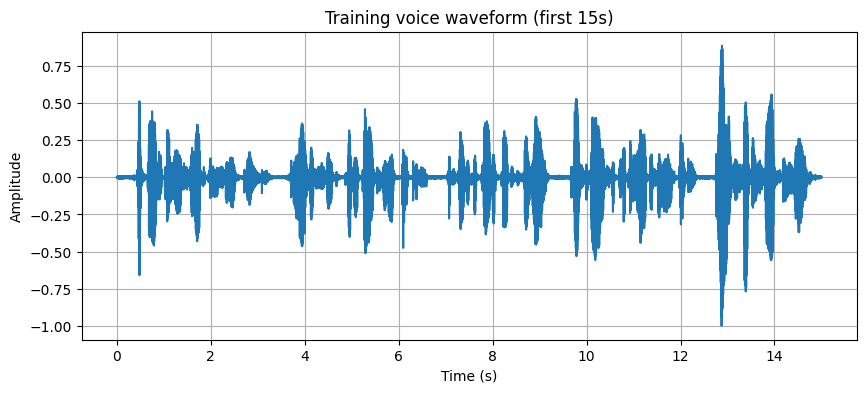

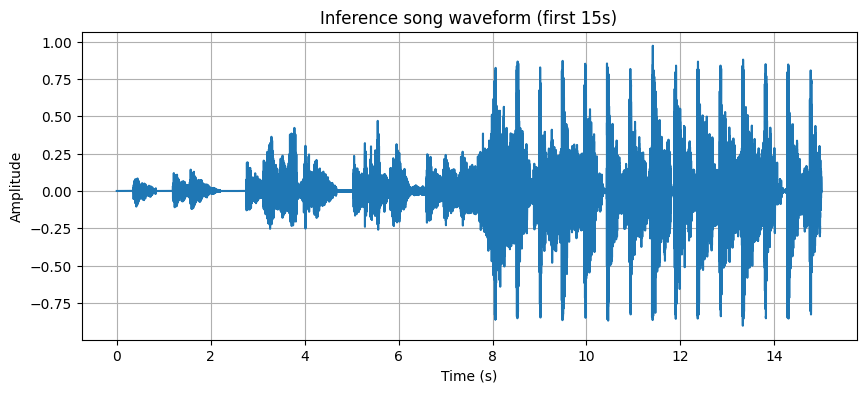

In [ ]:
# Wglad w wyglad sygnalu
def plot_waveform(audio: np.ndarray, sr: int, title: str, max_sec: float = 15.0):
    n_samples = min(len(audio), int(max_sec * sr))
    t = np.arange(n_samples) / sr
    plt.figure()
    plt.plot(t, audio[:n_samples])
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.show()


if len(train_files) == 0:
    raise RuntimeError("No training audio files found. Please set TRAIN_AUDIO_DIR correctly.")

train_example_path = train_files[0]
train_audio, sr_train = load_audio(train_example_path)

inf_audio, sr_inf = load_audio(INFERENCE_AUDIO_PATH)

print("Train sample:", train_example_path)
print("Train audio shape:", train_audio.shape, "SR:", sr_train)
print("Inference audio shape:", inf_audio.shape, "SR:", sr_inf)

plot_waveform(train_audio, sr_train, "Training voice waveform (first 15s)")
plot_waveform(inf_audio, sr_inf, "Inference song waveform (first 15s)")


- Sygnały są poprawnie wczytane, znormalizowane i zresamplowane do formatu akceptowanego przez modele.
- Różnica struktury (mowa vs piosenka) jest zgodna z przeznaczeniem RVC: trenowanie na czystej mowie, inferencja na złożonym sygnale muzycznym.

Kolejnym wnikliwym krokiem będzie zbadanie typów spektogramów plików audio. Definiujemy funkcje do liczenia spektrogramu STFT i mel-spektrogramu.
Dla nagrania treningowego i piosenki liczone są:
- spektrogramy (częstotliwość, a czas),
- mel-spektrogramy (typ spektogramu bardziej ustyuowany do wizualizacji dźwięków z częstotliwości odbieranych lepiej przez ludzkie ucho).

Wyniki są wizualizowane w postaci heatmap (osie: czas/częstotliwość).

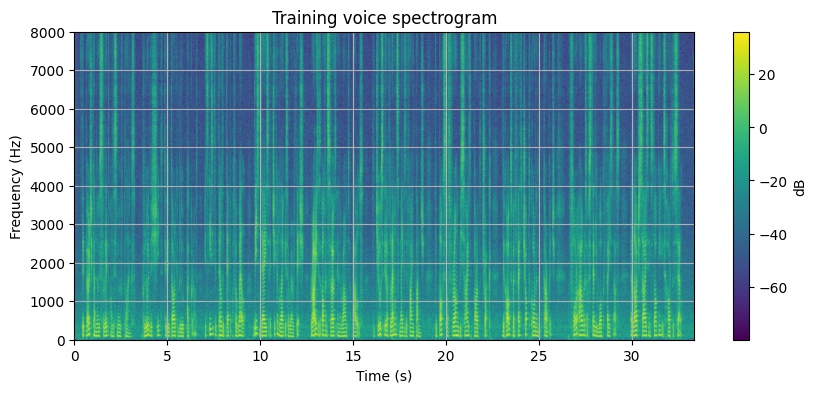

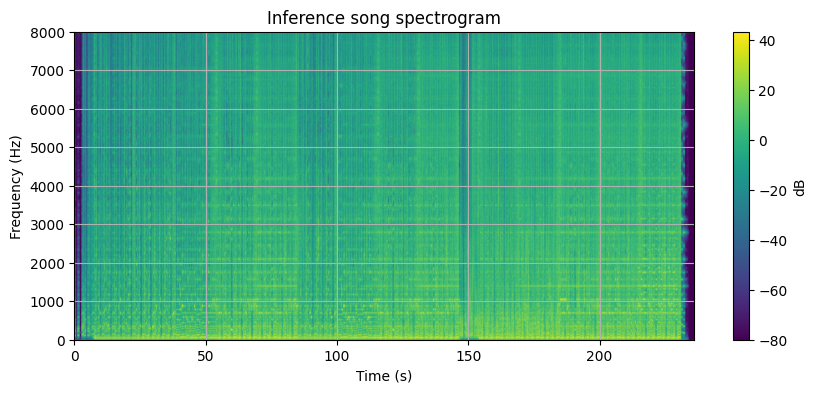

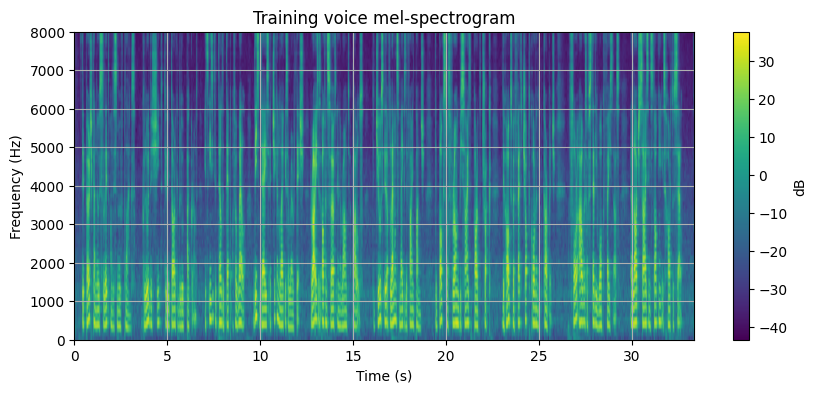

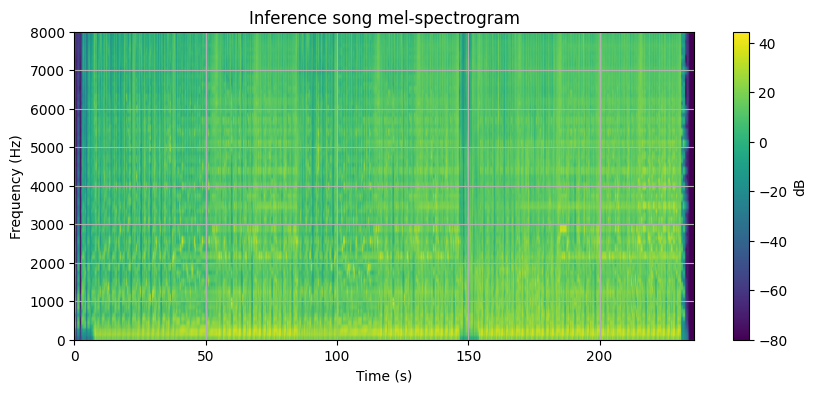

In [ ]:
# spektogramy, definicje spektogramów, mel-spektogramów oraz ich porówanie
def plot_spectrogram(spec: torch.Tensor, sr: int, hop_length: int, title: str):
    spec_db = 10 * torch.log10(spec + 1e-8)
    plt.figure(figsize=(10, 4))
    plt.imshow(spec_db.numpy(), origin="lower", aspect="auto",
               extent=[0, spec_db.shape[1] * hop_length / sr, 0, sr / 2])
    plt.colorbar(label="dB")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    plt.show()


def compute_spectrogram(audio: np.ndarray, sr: int, n_fft: int = 1024, hop_length: int = 256):
    wav_tensor = torch.from_numpy(audio).unsqueeze(0)  # [1, T]
    spec_transform = T.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=2.0)
    spec = spec_transform(wav_tensor).squeeze(0)  # [freq, time]
    return spec, hop_length


def compute_melspectrogram(audio: np.ndarray, sr: int, n_fft: int = 1024, hop_length: int = 256, n_mels: int = 80):
    wav_tensor = torch.from_numpy(audio).unsqueeze(0)
    mel_transform = T.MelSpectrogram(
        sample_rate=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
    )
    mel = mel_transform(wav_tensor).squeeze(0)  # [n_mels, time]
    return mel, hop_length


train_spec, hop = compute_spectrogram(train_audio, sr_train)
plot_spectrogram(train_spec, sr_train, hop, "Training voice spectrogram")

inf_spec, hop_inf = compute_spectrogram(inf_audio, sr_inf)
plot_spectrogram(inf_spec, sr_inf, hop_inf, "Inference song spectrogram")

train_mel, hop_mel = compute_melspectrogram(train_audio, sr_train)
plot_spectrogram(train_mel, sr_train, hop_mel, "Training voice mel-spectrogram")

inf_mel, hop_mel_inf = compute_melspectrogram(inf_audio, sr_inf)
plot_spectrogram(inf_mel, sr_inf, hop_mel_inf, "Inference song mel-spectrogram")


- Mowa treningowa ma skoncentrowaną energię w niskich i średnich częstotliwościach.
- Piosenka ma szersze widmo (instrumenty, perkusja), co potwierdza trudniejszy, ale typowy dla RVC przypadek wejściowy.

Następnie obliczamy cechy:
- RMS (moc sygnału, głośność),
- spectral centroid (miara "jasności" sygnału),
- ZCR (zero-crossing rate, powiązany z szumowością),
- ZCR dla nagrania treningowego i piosenki jest wypisywany liczbowo,

Training ZCR: 2105.3506913814704
Inference ZCR: 2071.622042308254


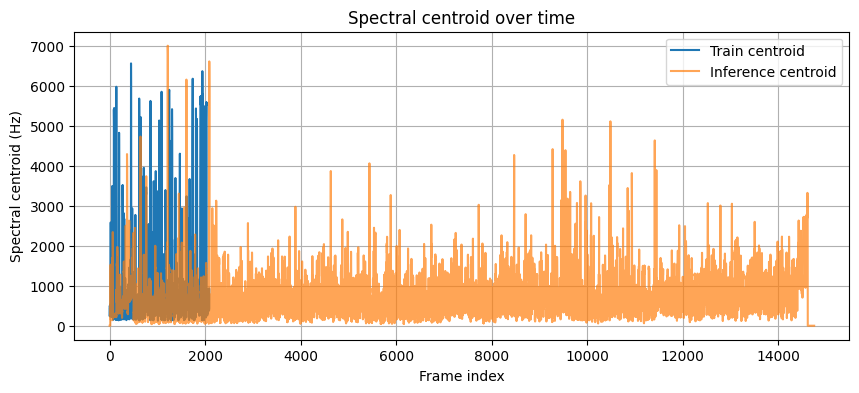

In [13]:
def compute_basic_features(audio: np.ndarray, sr: int, frame_length: int = 1024, hop_length: int = 256):
    wav_tensor = torch.from_numpy(audio).unsqueeze(0)  # [1, T]

    rms_transform = T.AmplitudeToDB(stype="power")
    spec_transform = T.Spectrogram(n_fft=frame_length, hop_length=hop_length, power=2.0)

    spec = spec_transform(wav_tensor)  # [1, freq, time]

    power = spec.mean(dim=1)  # [1, time]
    rms_db = rms_transform(power)  # [1, time]

    freqs = torch.linspace(0, sr / 2, spec.shape[1])
    spec_norm = spec / (spec.sum(dim=1, keepdim=True) + 1e-8)
    centroid = (spec_norm * freqs.view(1, -1, 1)).sum(dim=1)  # [1, time]

    x = audio
    zero_crossings = np.where(np.diff(np.sign(x)))[0]
    zcr = len(zero_crossings) / (len(x) / sr)

    return {
        "rms_db": rms_db.squeeze(0).numpy(),
        "centroid_hz": centroid.squeeze(0).numpy(),
        "zcr": zcr,
    }


train_feats = compute_basic_features(train_audio, sr_train)
inf_feats = compute_basic_features(inf_audio, sr_inf)

print("Training ZCR:", train_feats["zcr"])
print("Inference ZCR:", inf_feats["zcr"])

plt.figure()
plt.plot(train_feats["centroid_hz"], label="Train centroid")
plt.plot(inf_feats["centroid_hz"], label="Inference centroid", alpha=0.7)
plt.xlabel("Frame index")
plt.ylabel("Spectral centroid (Hz)")
plt.title("Spectral centroid over time")
plt.legend()
plt.show()


- Rozkłady centroidu i ZCR wskazują na poprawny, naturalny charakter nagrań (brak skrajnie szumowych lub przesterowanych fragmentów).
- Piosenka ma wyraźniej podwyższony i bardziej zmienny "spectral centroid", co jest typowe dla utworu muzycznego.

W poniższej komórce definiujemy:
- funkcję `segment_audio_by_energy`: liczy spektrogram, sumuje energię w czasie, normalizuje ją i porównuje z pewnym przyjętym progiem (progiem wyróżniającym szum od mowy).

Powstają segmenty "voiced" (powyżej progu energii, powyżej minimalnej długości).

Na wykresie sygnału zaznaczone są przedziały czasowe tych segmentów (półprzezroczyste prostokąty).

Found 17 segments in train example.


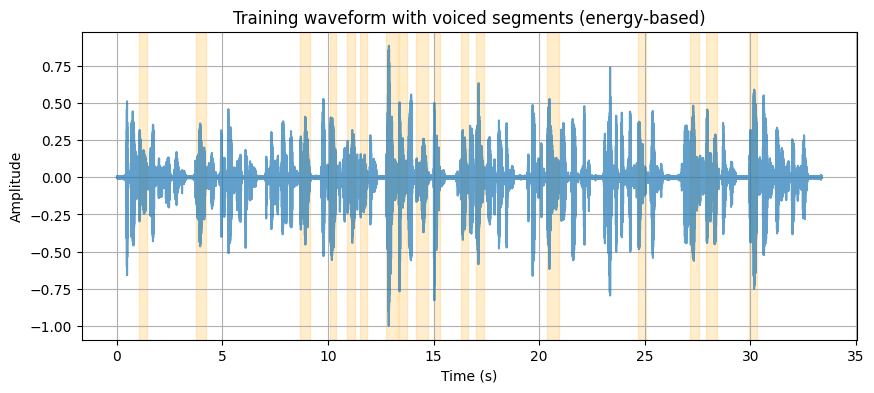

In [ ]:
# %%
def segment_audio_by_energy(
    audio: np.ndarray,
    sr: int,
    frame_length: int = 2048,
    hop_length: int = 512,
    energy_threshold: float = 0.01,
    min_segment_sec: float = 0.3,
) -> List[Tuple[int, int]]:
    
    wav_tensor = torch.from_numpy(audio).unsqueeze(0)
    spec_transform = T.Spectrogram(n_fft=frame_length, hop_length=hop_length, power=2.0)
    spec = spec_transform(wav_tensor)  # [1, freq, time]
    energy = spec.sum(dim=1).squeeze(0)  # [time]

    energy = (energy / energy.max()).numpy()
    voiced = energy > energy_threshold

    segments = []
    in_segment = False
    start_idx = 0

    for i, v in enumerate(voiced):
        if v and not in_segment:
            in_segment = True
            start_idx = i
        elif not v and in_segment:
            in_segment = False
            end_idx = i
            start_sample = start_idx * hop_length
            end_sample = end_idx * hop_length
            if (end_sample - start_sample) / sr >= min_segment_sec:
                segments.append((start_sample, end_sample))

    if in_segment:
        end_idx = len(voiced)
        start_sample = start_idx * hop_length
        end_sample = end_idx * hop_length
        if (end_sample - start_sample) / sr >= min_segment_sec:
            segments.append((start_sample, end_sample))

    return segments


train_segments = segment_audio_by_energy(train_audio, sr_train)
print(f"Found {len(train_segments)} segments in train example.")

plt.figure()
t = np.arange(len(train_audio)) / sr_train
plt.plot(t, train_audio, label="waveform", alpha=0.7)
for start, end in train_segments:
    plt.axvspan(start / sr_train, end / sr_train, color="orange", alpha=0.2)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Training waveform with voiced segments (energy-based)")
plt.show()


- Segmentacja poprawnie dzieli nagranie na zwięzłe fragmenty mowy, eliminując długie przerwy.
- Liczba segmentów jest rozsądna w stosunku do długości nagrania, co sugeruje poprawnie dobrany próg energii.
- Ten etap wyraźnie redukuje "martwe": dane i zwiększa efektywność dalszych kroków (HuBERT, FAISS, generator).

Zbadanie zachowania w kolejnym kroku jest kluczowe ze względu na działanie architektury.  
Za pomocą funkcji torchaudio.functional.detect_pitch_frequency do wyznaczenia częstotliwości F0 dla sygnału treningowego i piosenki.  
Rysujemy przebieg F0 w czasie dla obu oraz histogram F0 dla przedziałów z dodatnią częstotliwością.  
F0 jest jednym z głównych sygnałów sterujących w generatorze, odpowiada za wysokość głosu po konwersji.  

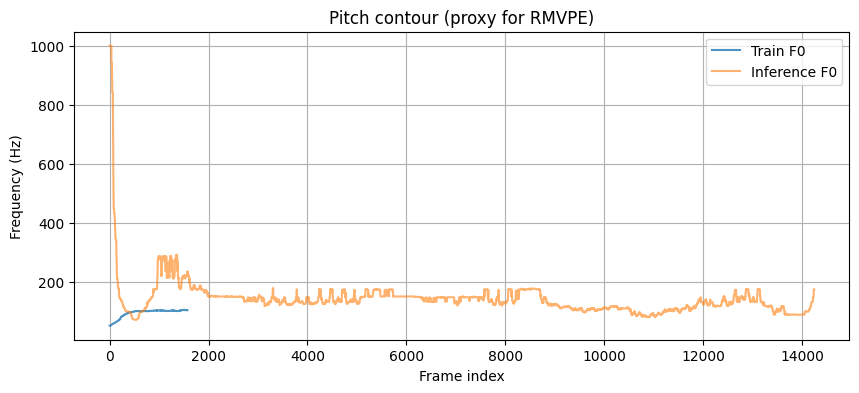

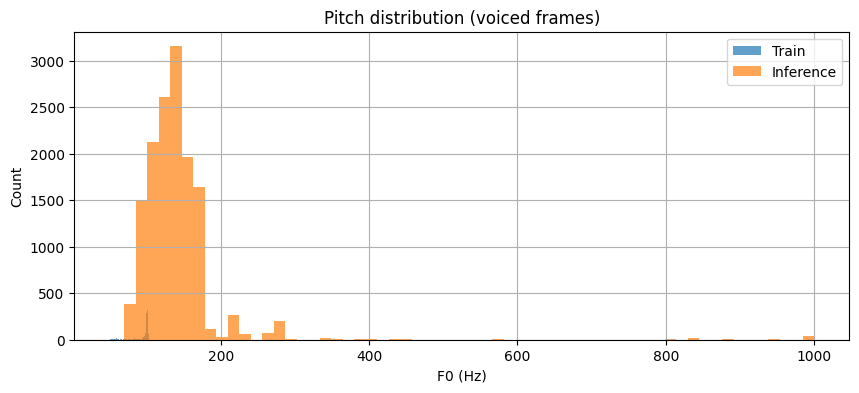

In [15]:
# %%
def extract_pitch_torchaudio(
    audio: np.ndarray,
    sr: int,
    frame_length: int = 1024,
    hop_length: int = 256,
    f_min: float = 50.0,
    f_max: float = 1100.0,
) -> np.ndarray:

    wav_tensor = torch.from_numpy(audio).unsqueeze(0)  # [1, T]

    pitch = torchaudio.functional.detect_pitch_frequency(
        wav_tensor,
        sample_rate=sr,
        frame_time=hop_length / sr,
        win_length=frame_length,
        freq_low=f_min,
        freq_high=f_max,
    )  # [1, time]

    return pitch.squeeze(0).numpy()


train_pitch = extract_pitch_torchaudio(train_audio, sr_train)
inf_pitch = extract_pitch_torchaudio(inf_audio, sr_inf)

plt.figure()
plt.plot(train_pitch, label="Train F0", alpha=0.8)
plt.plot(inf_pitch, label="Inference F0", alpha=0.6)
plt.xlabel("Frame index")
plt.ylabel("Frequency (Hz)")
plt.title("Pitch contour (proxy for RMVPE)")
plt.legend()
plt.show()

plt.figure()
plt.hist(train_pitch[train_pitch > 0], bins=60, alpha=0.7, label="Train")
plt.hist(inf_pitch[inf_pitch > 0], bins=60, alpha=0.7, label="Inference")
plt.xlabel("F0 (Hz)")
plt.ylabel("Count")
plt.title("Pitch distribution (voiced frames)")
plt.legend()
plt.show()


- F0 dla mowy mieści się w typowym zakresie dla ludzkiego głosu, co wskazuje na poprawność sygnału i algorytmu.
- Piosenka ma bardziej zróżnicowany F0, zgodny ze strukturą melodii.

W kolejnym etapie EDA:
- ładujemy model HUBERT_BASE z torchaudio.pipelines.
- `extract_hubert_features` resampluje audio do 16 kHz, przekazywana jest do HuBERT'a i zwraca macierz cech [czas, wymiar_cech].
Funkcja jest używana do wyznaczenia cech `train_hubert` i `inf_hubert`.

In [ ]:
# %%
# HuBert model
bundle = torchaudio.pipelines.HUBERT_BASE
hubert_model = bundle.get_model().to(DEVICE)
hubert_model.eval()

def extract_hubert_features(audio: np.ndarray, sr: int, target_sr: int = 16000) -> torch.Tensor:
    """
    Returns HuBert content features: [time, feature_dim]
    - Resamples audio to target_sr if needed.
    """
    wav_tensor = torch.from_numpy(audio).unsqueeze(0)  # [1, T]
    if sr != target_sr:
        resampler = T.Resample(orig_freq=sr, new_freq=target_sr)
        wav_tensor = resampler(wav_tensor)
        sr = target_sr

    wav_tensor = wav_tensor.to(DEVICE)

    with torch.no_grad():
        features, _ = hubert_model(wav_tensor) # [batch, time, feature_dim]
    return features.squeeze(0).cpu()  # [time, feature_dim]


train_hubert = extract_hubert_features(train_audio, sr_train)
inf_hubert = extract_hubert_features(inf_audio, sr_inf)

print("HuBert train features:", train_hubert.shape)
print("HuBert inference features:", inf_hubert.shape)


HuBert train features: torch.Size([1668, 768])
HuBert inference features: torch.Size([11804, 768])


Te wektory są później wykorzystywane przez index FAISS i generator jako podstawy budulcowe do generatora.  
Wymiary cech są zgodne z oczekiwaniami (typowo 768 dla bazowej wersji HuBert'a).

Wizualizacja cech otrzymanych od Hubert'a.  
Implementowana PCA w oparciu o SVD, redukująca wymiar cech HuBERT do 2.  
Z obu zbiorów (trening, inferencja) pobierana jest próbka ramek (domyślnie 5000).

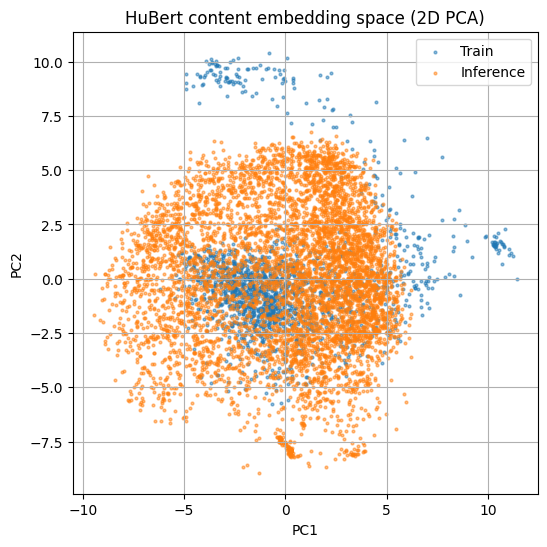

In [17]:
def simple_pca_2d(features: np.ndarray) -> np.ndarray:
    X = features - features.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    return X @ Vt[:2].T

max_frames = 5000
train_sub = train_hubert[:: max(1, train_hubert.shape[0] // max_frames)]
inf_sub = inf_hubert[:: max(1, inf_hubert.shape[0] // max_frames)]

train_pca = simple_pca_2d(train_sub.numpy())
inf_pca = simple_pca_2d(inf_sub.numpy())

plt.figure(figsize=(6, 6))
plt.scatter(train_pca[:, 0], train_pca[:, 1], s=4, alpha=0.5, label="Train")
plt.scatter(inf_pca[:, 0], inf_pca[:, 1], s=4, alpha=0.5, label="Inference")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("HuBert content embedding space (2D PCA)")
plt.legend()
plt.show()


- Częściowe nakładanie się "chmur" punktów wskazuje, że piosenka jest w podobnej przestrzeni treściowej co dane treningowe.
- Brak ewidentnej separacji sugeruje, że model RVC będzie miał szansę sensownie odwzorować treść piosenki na głos uczony z tych nagrań.
- Gdyby "chmury" były zupełnie rozłączne, należałoby rozważyć więcej danych treningowych lub inny encoder treści.

Kolejnym krokiem będzie połączenie cech Hubert'a oraz uzyskanych częstotliwości bazowych F0:
- `align_pitch_to_hubert` interpoluje sekwencję F0, aby liczba ramek F0 odpowiadała liczbie ramek cech HuBERT.
- Dla treningu i piosenki tworzona jest macierz cech [czas, wymiar_HuBERT + 1], gdzie ostatnia kolumna wektor F0.
- Wypisywane są wymiary powstałych macierzy.

In [18]:
def align_pitch_to_hubert(pitch: np.ndarray, hubert_len: int) -> np.ndarray:

    if len(pitch) == hubert_len:
        return pitch
    x_old = np.linspace(0, 1, len(pitch))
    x_new = np.linspace(0, 1, hubert_len)
    return np.interp(x_new, x_old, pitch)


train_pitch_aligned = align_pitch_to_hubert(train_pitch, train_hubert.shape[0])
inf_pitch_aligned = align_pitch_to_hubert(inf_pitch, inf_hubert.shape[0])

train_feature_full = np.concatenate(
    [train_hubert.numpy(), train_pitch_aligned[:, None]], axis=1
) 
inf_feature_full = np.concatenate(
    [inf_hubert.numpy(), inf_pitch_aligned[:, None]], axis=1
)

print("Train feature (content+pitch):", train_feature_full.shape)
print("Inference feature (content+pitch):", inf_feature_full.shape)


Train feature (content+pitch): (1668, 769)
Inference feature (content+pitch): (11804, 769)


Kolejnym kluczowym krokiem w architekturze jest budowa indeksu FAISS (i wszystkie poprzedzające je kroki):
- `collect_training_embeddings` przechodzi po wybranej liczbie plików treningowych:
- dla każdego pliku liczy cechy HuBERT'a,
- sampluljemy liczbę ramek do ustalonego maksimum,
- składamy wszystko w jedną macierz `train_embeddings` rozmiaru [N, D].
- tworzona jest ramka `train_embed_meta` z mapowaniem: indeks w macierzy -> ścieżka pliku, numer pliku, indeks ramki.
- `build_faiss_index` tworzy indeks IndexFlatL2 (odległość euklidesowa L2) i dodaje do niego embeddingi.

Wypisujemy są: rozmiar macierzy embeddingów i rozmiar indeksu FAISS.

In [19]:
def build_faiss_index(embeddings: np.ndarray) -> faiss.IndexFlatL2:
    assert embeddings.dtype == np.float32
    d = embeddings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(embeddings)
    return index


def collect_training_embeddings(
    files: List[Path],
    max_files: int = 50,
    max_frames_per_file: int = 2000,
) -> Tuple[np.ndarray, pd.DataFrame]:
    rows = []
    meta = []

    for idx, path in enumerate(tqdm(files[:max_files], desc="Collecting train embeddings")):
        audio, sr = load_audio(path)
        feats = extract_hubert_features(audio, sr)  # [T, D]
        if feats.shape[0] > max_frames_per_file:
            feats = feats[:: feats.shape[0] // max_frames_per_file]
        n = feats.shape[0]
        rows.append(feats.numpy())
        meta.extend(
            [
                {"file_idx": idx, "file_path": str(path), "frame_idx": i}
                for i in range(n)
            ]
        )
    if not rows:
        raise RuntimeError("No training embeddings collected.")

    all_embeddings = np.concatenate(rows, axis=0).astype(np.float32)
    meta_df = pd.DataFrame(meta)
    return all_embeddings, meta_df


train_embeddings, train_embed_meta = collect_training_embeddings(train_files, max_files=30)
print("Training embedding matrix:", train_embeddings.shape)
display(train_embed_meta.head())

faiss_index = build_faiss_index(train_embeddings)
print("FAISS index size:", faiss_index.ntotal)


Training embedding matrix: (7895, 768)


,file_idx,file_path,frame_idx
0,0,..\data\my_voice\List_1.wav,0
1,0,..\data\my_voice\List_1.wav,1
2,0,..\data\my_voice\List_1.wav,2
3,0,..\data\my_voice\List_1.wav,3
4,0,..\data\my_voice\List_1.wav,4


FAISS index size: 7895


W kolejnym etapie przetestujemy index FAISS:
- Z embeddingów HuBERT dla piosenki wybierana jest próbka ramek .
- Dla każdej wybranej ramki wykonywane jest zapytanie `faiss_index.search` z k najbliższymi sąsiadami.
- Rysowany jest histogram odległości L2 pomiędzy ramkami piosenki a ich najbliższymi sąsiadami w zbiorze treningowym.
- Funkcja `inspect_neighbor` wypisuje szczegóły sąsiadów dla kilku wybranych ramek: indeks pliku, indeks ramki, ścieżka, odległość.

Distances shape: (1074, 5)
Indices shape: (1074, 5)


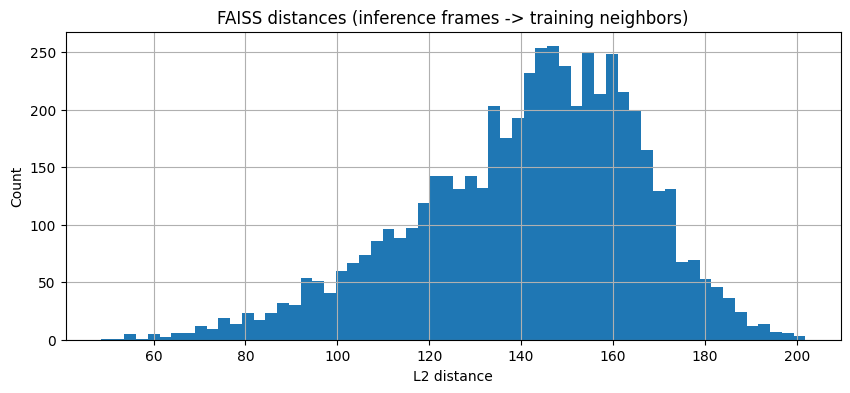

Query frame 0
  Neighbor 1: dist=112.2424, file_idx=3, frame_idx=1474, path=..\data\my_voice\List_4.wav
  Neighbor 2: dist=113.0607, file_idx=3, frame_idx=1478, path=..\data\my_voice\List_4.wav
  Neighbor 3: dist=114.5702, file_idx=3, frame_idx=1473, path=..\data\my_voice\List_4.wav
  Neighbor 4: dist=115.0956, file_idx=3, frame_idx=1480, path=..\data\my_voice\List_4.wav
  Neighbor 5: dist=115.2626, file_idx=3, frame_idx=1472, path=..\data\my_voice\List_4.wav
Query frame 537
  Neighbor 1: dist=179.7205, file_idx=1, frame_idx=533, path=..\data\my_voice\List_2.wav
  Neighbor 2: dist=180.7868, file_idx=2, frame_idx=701, path=..\data\my_voice\List_3.wav
  Neighbor 3: dist=181.6164, file_idx=1, frame_idx=530, path=..\data\my_voice\List_2.wav
  Neighbor 4: dist=183.9520, file_idx=2, frame_idx=700, path=..\data\my_voice\List_3.wav
  Neighbor 5: dist=184.1638, file_idx=1, frame_idx=529, path=..\data\my_voice\List_2.wav
Query frame 1073
  Neighbor 1: dist=67.5619, file_idx=3, frame_idx=1481, pa

In [20]:
max_query_frames = 1000
inf_query = inf_hubert[:: max(1, inf_hubert.shape[0] // max_query_frames)].numpy().astype(np.float32)

k = 5 
distances, indices = faiss_index.search(inf_query, k)  # [Q, k]

print("Distances shape:", distances.shape)
print("Indices shape:", indices.shape)

plt.figure()
plt.hist(distances.flatten(), bins=60)
plt.xlabel("L2 distance")
plt.ylabel("Count")
plt.title("FAISS distances (inference frames -> training neighbors)")
plt.show()

def inspect_neighbor(q_idx: int):
    print(f"Query frame {q_idx}")
    for rank in range(k):
        idx = indices[q_idx, rank]
        dist = distances[q_idx, rank]
        row = train_embed_meta.iloc[idx]
        print(
            f"  Neighbor {rank+1}: dist={dist:.4f}, "
            f"file_idx={row.file_idx}, frame_idx={row.frame_idx}, "
            f"path={row.file_path}"
        )

inspect_neighbor(0)
inspect_neighbor(len(inf_query) // 2)
inspect_neighbor(len(inf_query) - 1)

Histogram odległości wskazuje, że większość ramek piosenki ma sensownych sąsiadów o stosunkowo małych odległościach L2, co oznacza, że embeddingi inference są zbliżone do embeddingów treningowych.  
Lista sąsiadów pokazuje, że system znajduje powtarzalne fragmenty głosu w różnych plikach, co jest pożądane z perspektywy stabilności konwersji.

Uruchomienie dotychczasowego stanu architektury został zaprezentowany w notatniku `notebook.ipynb`, gdzie możemy przejść przez każdy krok ładowania danych, treningu oraz inferencji naszej architektury.